In [361]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import json
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
house_file = pd.read_csv('../data/cleaned_complete.csv').drop(['Unnamed: 0.1','Unnamed: 0', 'index','dateUpdated','dateListed','geoLocation','geometry', 'index_right', 'SA2_maincode_2021','Population Increase','Earners (persons)','Median age of earners (years)','Male','Female','Person','Male Ratio','Female Ratio','Sum ($)','Mean ($)','Median ($)','propertyTypes','price'],axis = 1)


In [362]:
income = pd.read_excel('../data/Income.xlsx',sheet_name="Forecasted Income", header=[0,1]).drop([(           'Unnamed: 0_level_0',      'SA2')], axis = 1)
income[(           'Unnamed: 2_level_0', 'Postcode')] = income[(           'Unnamed: 2_level_0', 'Postcode')].fillna(0)

In [363]:
name_income_dict = dict()
postcode_income_dict = dict()
for index, item in income.iterrows():
    name = item[(           'Unnamed: 1_level_0', 'SA2 NAME')].lower().replace('- ','')
    postcode_income = int(item[(           'Unnamed: 2_level_0', 'Postcode')])
    name_income_dict[name] = item
    postcode_income_dict[postcode_income] = item

def search_income(suburb_name,postcode):
    item = name_income_dict.get(suburb_name)
    if item is not None:
        return item
    item = postcode_income_dict.get(postcode)
    if item is not None:
        return item    
    return None


In [364]:
income_list = []
l = []
col = None
for index, value in house_file.iterrows():
    item = search_income(value['surburb'], value['postcode'])
    if item is not None:
        l.append(list(item))
        col = item.index
    else:
        l.append([None]*len(col))

In [365]:
income = pd.DataFrame(l, columns=['SA2 NAME','Postcode','Earners_2019','Earners_2020','Earners_2021','Earners_2022','Median_age_2019','Median_age_2020','Median_age_2021','Median_age_2022','sum_2019','sum_2020','sum_2021','sum_2022','median_2019','median_2020','median_2021','median_2022','mean_2019','mean_2020','mean_2021','mean_2022'])
house_original = pd.concat([house_file, income],axis=1)

In [372]:
house_original[house_original['Postcode'] > 0]

,bathrooms,bedrooms,carspaces,landAreaSqm,postcode,surburb,year,month,bond,rent,...,sum_2021,sum_2022,median_2019,median_2020,median_2021,median_2022,mean_2019,mean_2020,mean_2021,mean_2022
0,1.0,1.0,0.0,NaN,3205,south melbourne,2019,1,NaN,360.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
1,2.0,2.0,1.0,NaN,3205,south melbourne,2019,1,NaN,725.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
2,1.0,2.0,0.0,NaN,3205,south melbourne,2019,1,NaN,500.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
3,1.0,3.0,0.0,NaN,3205,south melbourne,2019,1,NaN,795.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
4,2.0,2.0,0.0,NaN,3205,south melbourne,2019,1,NaN,825.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100629,1.0,3.0,1.0,NaN,3701,dartmouth,2021,2,NaN,250.0,...,2.240127e+08,2.293470e+08,41070.537894,42207.801316,43272.563277,44583.025987,44794.347421,45114.652912,45129.772942,45276.629966
100631,1.0,3.0,1.0,NaN,3701,dartmouth,2021,10,NaN,300.0,...,2.240127e+08,2.293470e+08,41070.537894,42207.801316,43272.563277,44583.025987,44794.347421,45114.652912,45129.772942,45276.629966
100634,1.0,3.0,1.0,NaN,3701,dartmouth,2022,5,NaN,280.0,...,2.240127e+08,2.293470e+08,41070.537894,42207.801316,43272.563277,44583.025987,44794.347421,45114.652912,45129.772942,45276.629966
100635,1.0,3.0,1.0,NaN,3701,dartmouth,2022,6,NaN,290.0,...,2.240127e+08,2.293470e+08,41070.537894,42207.801316,43272.563277,44583.025987,44794.347421,45114.652912,45129.772942,45276.629966


In [380]:
house_original[house_original['sum_2021'] > 0]

,bathrooms,bedrooms,carspaces,landAreaSqm,postcode,surburb,year,month,bond,rent,...,sum_2021,sum_2022,median_2019,median_2020,median_2021,median_2022,mean_2019,mean_2020,mean_2021,mean_2022
0,1.0,1.0,0.0,NaN,3205,south melbourne,2019,1,NaN,360.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
1,2.0,2.0,1.0,NaN,3205,south melbourne,2019,1,NaN,725.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
2,1.0,2.0,0.0,NaN,3205,south melbourne,2019,1,NaN,500.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
3,1.0,3.0,0.0,NaN,3205,south melbourne,2019,1,NaN,795.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
4,2.0,2.0,0.0,NaN,3205,south melbourne,2019,1,NaN,825.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100629,1.0,3.0,1.0,NaN,3701,dartmouth,2021,2,NaN,250.0,...,2.240127e+08,2.293470e+08,41070.537894,42207.801316,43272.563277,44583.025987,44794.347421,45114.652912,45129.772942,45276.629966
100631,1.0,3.0,1.0,NaN,3701,dartmouth,2021,10,NaN,300.0,...,2.240127e+08,2.293470e+08,41070.537894,42207.801316,43272.563277,44583.025987,44794.347421,45114.652912,45129.772942,45276.629966
100634,1.0,3.0,1.0,NaN,3701,dartmouth,2022,5,NaN,280.0,...,2.240127e+08,2.293470e+08,41070.537894,42207.801316,43272.563277,44583.025987,44794.347421,45114.652912,45129.772942,45276.629966
100635,1.0,3.0,1.0,NaN,3701,dartmouth,2022,6,NaN,290.0,...,2.240127e+08,2.293470e+08,41070.537894,42207.801316,43272.563277,44583.025987,44794.347421,45114.652912,45129.772942,45276.629966


In [381]:
house = house_original[house_original['sum_2021'] > 0].reset_index().drop('index', axis = 1)


In [374]:
house = house.fillna(0)
value_list = []
for index, values in house.iterrows():
    year = values['year']
    column_list = list(values.index)[:44]
    for i in list(values.index)[44:]:
        if str(year) in i:
            column_list.append(i)
    new_value = values[column_list]
    value_list.append(list(new_value))
file = pd.DataFrame(value_list, columns = column_list).rename({'Earners_2021':'Earners', 'Median_age_2021':'Median_age', 'sum_2021':'sum', 'median_2021':'median',	'mean_2021':'mean'}, axis = 1)

In [382]:
file

,bathrooms,bedrooms,carspaces,landAreaSqm,postcode,surburb,year,month,bond,rent,...,offence count,incidents recorded,Population,SA2 NAME,Postcode,Earners,Median_age,sum,median,mean
0,1.0,1.0,0.0,0.0,3205,south melbourne,2019,1,0.0,360.0,...,22895.0,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940
1,2.0,2.0,1.0,0.0,3205,south melbourne,2019,1,0.0,725.0,...,22895.0,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940
2,1.0,2.0,0.0,0.0,3205,south melbourne,2019,1,0.0,500.0,...,22895.0,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940
3,1.0,3.0,0.0,0.0,3205,south melbourne,2019,1,0.0,795.0,...,22895.0,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940
4,2.0,2.0,0.0,0.0,3205,south melbourne,2019,1,0.0,825.0,...,22895.0,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86095,1.0,3.0,1.0,0.0,3701,dartmouth,2021,2,0.0,250.0,...,302.0,230.0,6153.000000,Bruthen - Omeo,3701.0,4963.045082,48.143569,2.240127e+08,43272.563277,45129.772942
86096,1.0,3.0,1.0,0.0,3701,dartmouth,2021,10,0.0,300.0,...,302.0,230.0,6153.000000,Bruthen - Omeo,3701.0,4963.045082,48.143569,2.240127e+08,43272.563277,45129.772942
86097,1.0,3.0,1.0,0.0,3701,dartmouth,2022,5,0.0,280.0,...,302.0,230.0,6181.185987,Bruthen - Omeo,3701.0,4963.045082,47.856776,2.293470e+08,44583.025987,45276.629966
86098,1.0,3.0,1.0,0.0,3701,dartmouth,2022,6,0.0,290.0,...,302.0,230.0,6181.185987,Bruthen - Omeo,3701.0,4963.045082,47.856776,2.293470e+08,44583.025987,45276.629966


In [383]:
file.to_csv('../data/curated/join.csv')

In [384]:
house_file = pd.read_csv('../data/curated/join.csv')
house_file

,Unnamed: 0,bathrooms,bedrooms,carspaces,landAreaSqm,postcode,surburb,year,month,bond,...,offence count,incidents recorded,Population,SA2 NAME,Postcode,Earners,Median_age,sum,median,mean
0,0,1.0,1.0,0.0,0.0,3205,south melbourne,2019,1,0.0,...,22895.0,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940
1,1,2.0,2.0,1.0,0.0,3205,south melbourne,2019,1,0.0,...,22895.0,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940
2,2,1.0,2.0,0.0,0.0,3205,south melbourne,2019,1,0.0,...,22895.0,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940
3,3,1.0,3.0,0.0,0.0,3205,south melbourne,2019,1,0.0,...,22895.0,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940
4,4,2.0,2.0,0.0,0.0,3205,south melbourne,2019,1,0.0,...,22895.0,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86095,86095,1.0,3.0,1.0,0.0,3701,dartmouth,2021,2,0.0,...,302.0,230.0,6153.000000,Bruthen - Omeo,3701.0,4963.045082,48.143569,2.240127e+08,43272.563277,45129.772942
86096,86096,1.0,3.0,1.0,0.0,3701,dartmouth,2021,10,0.0,...,302.0,230.0,6153.000000,Bruthen - Omeo,3701.0,4963.045082,48.143569,2.240127e+08,43272.563277,45129.772942
86097,86097,1.0,3.0,1.0,0.0,3701,dartmouth,2022,5,0.0,...,302.0,230.0,6181.185987,Bruthen - Omeo,3701.0,4963.045082,47.856776,2.293470e+08,44583.025987,45276.629966
86098,86098,1.0,3.0,1.0,0.0,3701,dartmouth,2022,6,0.0,...,302.0,230.0,6181.185987,Bruthen - Omeo,3701.0,4963.045082,47.856776,2.293470e+08,44583.025987,45276.629966


Filter out houses with abnormal rent ()

In [385]:
median_price = house_file.groupby(['bathrooms', 'bedrooms', 'carspaces','year','postcode'],as_index = False)['rent'].median('rent')
median_rent = dict()
for index, values in median_price.iterrows():
    year = values['year']
    bathrooms = values['bathrooms']
    bedrooms = values['bedrooms']
    carspaces = values['carspaces']
    postcode = values['postcode']
    key = postcode+year+bathrooms+bedrooms+carspaces
    median_rent[key] = values['rent']
values_list = []
for item,values in house_file.iterrows():
    year = values['year']
    bathrooms = values['bathrooms']
    bedrooms = values['bedrooms']
    carspaces = values['carspaces']
    postcode = values['postcode']
    key = postcode+year+bathrooms+bedrooms+carspaces
    hit = median_rent[key]
    values_list.append(hit)
house_file['median_rent'] = values_list 
# house_file = house_file[house_file['rent'] <= 1.5 * house_file['median_rent']]
house_file = house_file[house_file['rent'] > 0.1 * house_file['median_rent']]

In [386]:
house_file

,Unnamed: 0,bathrooms,bedrooms,carspaces,landAreaSqm,postcode,surburb,year,month,bond,...,incidents recorded,Population,SA2 NAME,Postcode,Earners,Median_age,sum,median,mean,median_rent
0,0,1.0,1.0,0.0,0.0,3205,south melbourne,2019,1,0.0,...,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,790.0
1,1,2.0,2.0,1.0,0.0,3205,south melbourne,2019,1,0.0,...,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,565.0
2,2,1.0,2.0,0.0,0.0,3205,south melbourne,2019,1,0.0,...,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,570.0
3,3,1.0,3.0,0.0,0.0,3205,south melbourne,2019,1,0.0,...,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,580.0
4,4,2.0,2.0,0.0,0.0,3205,south melbourne,2019,1,0.0,...,17201.0,12753.000000,South Melbourne,3004.0,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,580.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86095,86095,1.0,3.0,1.0,0.0,3701,dartmouth,2021,2,0.0,...,230.0,6153.000000,Bruthen - Omeo,3701.0,4963.045082,48.143569,2.240127e+08,43272.563277,45129.772942,275.0
86096,86096,1.0,3.0,1.0,0.0,3701,dartmouth,2021,10,0.0,...,230.0,6153.000000,Bruthen - Omeo,3701.0,4963.045082,48.143569,2.240127e+08,43272.563277,45129.772942,275.0
86097,86097,1.0,3.0,1.0,0.0,3701,dartmouth,2022,5,0.0,...,230.0,6181.185987,Bruthen - Omeo,3701.0,4963.045082,47.856776,2.293470e+08,44583.025987,45276.629966,285.0
86098,86098,1.0,3.0,1.0,0.0,3701,dartmouth,2022,6,0.0,...,230.0,6181.185987,Bruthen - Omeo,3701.0,4963.045082,47.856776,2.293470e+08,44583.025987,45276.629966,285.0


In [387]:
house_count = pd.DataFrame(house_file['postcode'].value_counts()).reset_index().rename({"index":"postcode",'postcode':'count'},axis = 1)
house_count

,postcode,count
0,3000,8960
1,3008,4254
2,3006,3135
3,3029,2824
4,3141,2586
...,...,...
272,3063,1
273,3610,1
274,3950,1
275,3221,1


In [388]:
df = house_file.groupby(['bathrooms','bedrooms','carspaces','postcode','year','month'],as_index= False).mean(['rent','distance of the closest bus stop','distance of the closest train stop','distance of the closest tram stop','distance of the closest vline stop','distance of the closest school','distance to the closest shopping mall']).drop(['landAreaSqm','longitude','latitude','median_rent','Postcode'],axis = 1)
df["postcode"] = df["postcode"].apply(lambda x: int(x))

In [389]:
df2 = house_file.groupby(['bathrooms','bedrooms','carspaces','postcode'],as_index= False).mean(['rent','distance of the closest bus stop','distance of the closest train stop','distance of the closest tram stop','distance of the closest vline stop','distance of the closest school','distance to the closest shopping mall']).drop(['landAreaSqm','longitude', 'latitude','year','month','Population ','Postcode','median_rent'],axis = 1)
df2 = df2.rename({'surburb':'suburb'}, axis = 1)
df2

,bathrooms,bedrooms,carspaces,postcode,Unnamed: 0,bond,rent,distance of the closest bus stop,count of bus stop,distance of the closest train stop,...,park,playground,pitch,offence count,incidents recorded,Earners,Median_age,sum,median,mean
0,0.0,1.0,0.0,3008,24490.0,5100.0,850.0,0.456268,5.0,0.000000,...,1.0,0.0,0.0,25125.0,18185.0,12852.879346,32.000000,9.131559e+08,55302.312878,71162.931348
1,0.0,1.0,0.0,3015,56337.0,1084.0,250.0,0.370457,60.0,0.405244,...,67.0,26.0,40.0,10604.0,8777.0,11895.330882,41.000000,1.028750e+09,72539.966775,86488.843304
2,0.0,1.0,0.0,3053,12565.0,0.0,175.0,0.449442,39.0,0.000000,...,19.0,8.0,24.0,20238.0,15867.0,11346.820188,29.126605,7.687387e+08,39659.346275,64056.803616
3,0.0,1.0,0.0,3079,36848.0,1304.0,300.0,0.516233,48.0,0.526467,...,20.0,14.0,42.0,9248.0,7527.0,9162.593440,41.054886,9.836557e+08,71134.720489,104102.687648
4,0.0,1.0,0.0,3171,69949.0,5000.0,460.0,0.642444,64.0,0.670534,...,5.0,4.0,12.0,22113.0,16777.0,13687.192327,34.379807,6.136552e+08,39079.025392,44830.558563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5442,4.0,5.0,3.0,3936,50381.0,1412.0,660.0,0.719518,25.0,0.000000,...,98.0,49.0,148.0,7669.0,5888.0,11643.706386,48.005102,5.916775e+08,42673.868649,50819.948012
5443,4.0,5.0,4.0,3064,77404.0,2340.0,540.0,0.386602,209.0,0.457571,...,119.0,48.0,190.0,55237.0,41689.0,5334.640894,45.000000,3.716333e+08,56175.284965,69640.550203
5444,4.0,5.0,4.0,3133,51929.0,0.0,900.0,0.642555,64.0,0.000000,...,4.0,0.0,2.0,7751.0,5998.0,6718.941929,44.000000,4.447596e+08,53075.761406,66204.887553
5445,4.0,5.0,4.0,3335,62281.0,2824.0,650.0,0.129284,10.0,0.000000,...,48.0,30.0,56.0,4762.0,3843.0,10763.212165,39.238456,6.540474e+08,55167.661340,59460.659575


In [390]:
df_combined = df.merge(house_count, on = 'postcode', how = 'left').fillna(0)

In [391]:
cpi_df = pd.read_csv('../data/cpi.csv').drop({'Unnamed: 0'}, axis = 1)
df_combined = df_combined.merge(cpi_df, on = 'year')

In [346]:
xls = pd.ExcelFile('../data/gdp.xlsx')
df1 = pd.read_excel(xls, 'Data')[36:].drop('Unnamed: 0', axis = 1).rename({'Unnamed: 1':'year','Unnamed: 2':'gdp'},axis = 1).reset_index().drop('index',axis = 1)
gdp_list = list(df1['gdp'])
l = []
m = 0
for i in range(2019,2026):
    l.append([i,gdp_list[m]])
    m = m+1
gdp_df = pd.DataFrame(l, columns=['year','gdp'])
gdp_df

,year,gdp
0,2019,54254.86
1,2020,52847.68
2,2021,63529.29
3,2022,67464.39
4,2023,69717.12
5,2024,72187.63
6,2025,74353.74


In [392]:
df_combined = df_combined.merge(gdp_df, on = 'year')

In [393]:
df_combined = df_combined.drop('Unnamed: 0', axis = 1).rename({'Population ':'population'}, axis = 1)

In [394]:
df_combined

,bathrooms,bedrooms,carspaces,postcode,year,month,bond,rent,distance of the closest bus stop,count of bus stop,...,incidents recorded,population,Earners,Median_age,sum,median,mean,count,cpi,gdp
0,0.0,1.0,0.0,3008,2019,12,5100.0,850.0,0.456268,5.0,...,18185.0,16375.0,12852.879346,32.000000,9.131559e+08,55302.312878,71162.931348,4254,255.65,54254.86
1,0.0,1.0,0.0,3015,2019,10,1084.0,250.0,0.370457,60.0,...,8777.0,19243.0,11895.330882,41.000000,1.028750e+09,72539.966775,86488.843304,296,255.65,54254.86
2,0.0,1.0,1.0,3070,2019,1,1390.0,320.0,0.456507,52.0,...,15386.0,16150.0,17319.564592,39.006579,1.495813e+09,66586.801117,86369.784653,418,255.65,54254.86
3,0.0,1.0,1.0,3216,2019,1,0.0,200.0,0.471810,204.0,...,22993.0,14956.0,8739.027560,39.756098,5.069019e+08,49187.916599,57999.541004,517,255.65,54254.86
4,0.0,2.0,0.0,3125,2019,2,826.0,190.0,0.575747,38.0,...,6487.0,13447.0,7519.899631,36.074422,4.108032e+08,35830.782819,54628.543097,300,255.65,54254.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37803,4.0,5.0,2.0,3187,2021,2,5400.0,900.0,0.516307,44.0,...,4527.0,16695.0,10687.520790,48.000000,1.199220e+09,68337.510700,112168.460011,149,264.71,63529.29
37804,4.0,5.0,2.0,3551,2021,7,0.0,620.0,0.949961,115.0,...,7363.0,8306.0,2982.644898,48.000000,1.778186e+08,52345.314199,59517.522515,110,264.71,63529.29
37805,4.0,5.0,3.0,3032,2021,4,0.0,700.0,0.363339,67.0,...,24502.0,12715.0,9635.042165,35.587081,6.848808e+08,57224.227353,71110.366384,505,264.71,63529.29
37806,4.0,5.0,3.0,3116,2021,2,0.0,900.0,0.778759,20.0,...,4736.0,11873.0,8021.328866,41.376224,5.616590e+08,60370.447780,70023.228213,60,264.71,63529.29


In [395]:
X = df_combined.drop('rent',axis=1)
y = df_combined['rent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)

In [396]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [207]:
regr = MLPRegressor(max_iter=500).fit(X_train_std, y_train)
regr.score(X_test_std, y_test)

/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8075887311079601

In [399]:
rfc = RandomForestRegressor(max_depth = 10)  
rfc = rfc.fit(X_train_std, y_train)
print(f'model score on training data: {rfc.score(X_train_std, y_train)}')
print(f'model score on testing data: {rfc.score(X_test_std, y_test)}')

model score on training data: 0.8685597915452761
model score on testing data: 0.8077192188227907


In [400]:
r = permutation_importance(rfc, X_train_std, y_train, n_repeats = 5, random_state = 0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_combined.drop('rent',axis = 1).columns[i]:<8}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

bedrooms0.402 +/- 0.003
bond    0.335 +/- 0.006
mean    0.294 +/- 0.005
bathrooms0.222 +/- 0.003
distance of the closest tram stop0.129 +/- 0.002
postcode0.054 +/- 0.002
distance of the closest school0.025 +/- 0.001
count   0.021 +/- 0.001
count of bus stop0.021 +/- 0.000
carspaces0.018 +/- 0.001
distance of the closest bus stop0.013 +/- 0.000
Median_age0.013 +/- 0.000
median  0.009 +/- 0.000
sum     0.008 +/- 0.000
count of tram stop0.007 +/- 0.000
cpi     0.007 +/- 0.000
distance of the closest vline stop0.006 +/- 0.000
year    0.006 +/- 0.000
population0.004 +/- 0.000
month   0.004 +/- 0.000
distance of the closest train stop0.004 +/- 0.000
gdp     0.004 +/- 0.000
count of vline stop0.004 +/- 0.000
Earners 0.003 +/- 0.000
bench   0.003 +/- 0.000
incidents recorded0.002 +/- 0.000
count of school0.002 +/- 0.000
distance to the closest shopping mall0.002 +/- 0.000
count of train stop0.002 +/- 0.000
offence count0.002 +/- 0.000
restaurant0.001 +/- 0.000
playground0.001 +/- 0.000
garden 

In [ ]:
xgbc = xgb.XGBRegressor(
    learning_rate = 0.1,
    n_estimators = 1000,
    max_depth = 4,
)
xgbc.fit(
    X_train, 
    y_train, 
    eval_set = [(X_train, y_train), (X_test, y_test)]
)
fea_imp = xgbc.feature_importances_
print(fea_imp)

<Axes:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

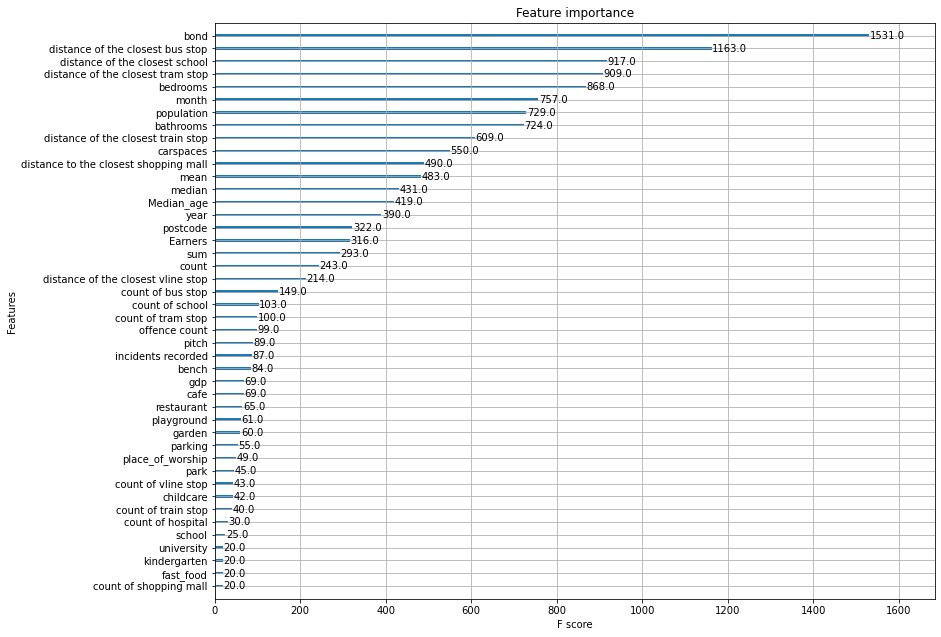

In [359]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_axes([0,0,1,1])
xgb.plot_importance(xgbc, ax)

In [401]:
df3 = pd.DataFrame()
for year in range(2023,2026):
    for month in range(1,13):
        tmp_df = df2.copy()
        year_list = [year]*len(df2)
        month_list = [month]*len(df2)
        tmp_df['year'] = year_list
        tmp_df['month'] = month_list
        df3= pd.concat([df3,tmp_df])
df3 = df3.reset_index().drop(['Unnamed: 0','index','rent'],axis = 1)
df3

,bathrooms,bedrooms,carspaces,postcode,bond,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,...,pitch,offence count,incidents recorded,Earners,Median_age,sum,median,mean,year,month
0,0.0,1.0,0.0,3008,5100.0,0.456268,5.0,0.000000,0.0,0.433269,...,0.0,25125.0,18185.0,12852.879346,32.000000,9.131559e+08,55302.312878,71162.931348,2023,1
1,0.0,1.0,0.0,3015,1084.0,0.370457,60.0,0.405244,2.0,0.000000,...,40.0,10604.0,8777.0,11895.330882,41.000000,1.028750e+09,72539.966775,86488.843304,2023,1
2,0.0,1.0,0.0,3053,0.0,0.449442,39.0,0.000000,0.0,0.452666,...,24.0,20238.0,15867.0,11346.820188,29.126605,7.687387e+08,39659.346275,64056.803616,2023,1
3,0.0,1.0,0.0,3079,1304.0,0.516233,48.0,0.526467,2.0,0.000000,...,42.0,9248.0,7527.0,9162.593440,41.054886,9.836557e+08,71134.720489,104102.687648,2023,1
4,0.0,1.0,0.0,3171,5000.0,0.642444,64.0,0.670534,2.0,0.000000,...,12.0,22113.0,16777.0,13687.192327,34.379807,6.136552e+08,39079.025392,44830.558563,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196087,4.0,5.0,3.0,3936,1412.0,0.719518,25.0,0.000000,0.0,0.000000,...,148.0,7669.0,5888.0,11643.706386,48.005102,5.916775e+08,42673.868649,50819.948012,2025,12
196088,4.0,5.0,4.0,3064,2340.0,0.386602,209.0,0.457571,2.0,0.000000,...,190.0,55237.0,41689.0,5334.640894,45.000000,3.716333e+08,56175.284965,69640.550203,2025,12
196089,4.0,5.0,4.0,3133,0.0,0.642555,64.0,0.000000,0.0,0.645158,...,2.0,7751.0,5998.0,6718.941929,44.000000,4.447596e+08,53075.761406,66204.887553,2025,12
196090,4.0,5.0,4.0,3335,2824.0,0.129284,10.0,0.000000,0.0,0.000000,...,56.0,4762.0,3843.0,10763.212165,39.238456,6.540474e+08,55167.661340,59460.659575,2025,12


In [402]:
population = pd.read_csv('../data/population_forcasting.csv')
population_count = dict()
population['Postcode'] = population['Postcode'].fillna(value=0)
for index, value in population.iterrows():
    postcode = int(value['Postcode'])
    year = value['year']
    key = str(postcode)+ ' ' + str(year)
    population_count[key] = value['Total']

In [403]:
population_list = []
for index, value in df3.iterrows():
    postcode = int(value['postcode'])
    year = int(value['year'])
    key = str(postcode)+ ' ' + str(year)
    try: 
        count = population_count[key]
        population_list.append(count)
    except:
        population_list.append(None)
df3['population'] = population_list

In [404]:
df3["postcode"] = df3["postcode"].apply(lambda x: int(x))
cpi_df = pd.read_csv('../data/cpi.csv')
df3 = df3.merge(cpi_df, on = 'year', how='left')

In [405]:
df3 = df3.drop('Unnamed: 0', axis = 1)
df3

,bathrooms,bedrooms,carspaces,postcode,bond,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,...,incidents recorded,Earners,Median_age,sum,median,mean,year,month,population,cpi
0,0.0,1.0,0.0,3008,5100.0,0.456268,5.0,0.000000,0.0,0.433269,...,18185.0,12852.879346,32.000000,9.131559e+08,55302.312878,71162.931348,2023,1,NaN,277.84
1,0.0,1.0,0.0,3015,1084.0,0.370457,60.0,0.405244,2.0,0.000000,...,8777.0,11895.330882,41.000000,1.028750e+09,72539.966775,86488.843304,2023,1,29726.0,277.84
2,0.0,1.0,0.0,3053,0.0,0.449442,39.0,0.000000,0.0,0.452666,...,15867.0,11346.820188,29.126605,7.687387e+08,39659.346275,64056.803616,2023,1,NaN,277.84
3,0.0,1.0,0.0,3079,1304.0,0.516233,48.0,0.526467,2.0,0.000000,...,7527.0,9162.593440,41.054886,9.836557e+08,71134.720489,104102.687648,2023,1,8946.0,277.84
4,0.0,1.0,0.0,3171,5000.0,0.642444,64.0,0.670534,2.0,0.000000,...,16777.0,13687.192327,34.379807,6.136552e+08,39079.025392,44830.558563,2023,1,9676.0,277.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196087,4.0,5.0,3.0,3936,1412.0,0.719518,25.0,0.000000,0.0,0.000000,...,5888.0,11643.706386,48.005102,5.916775e+08,42673.868649,50819.948012,2025,12,24312.0,291.50
196088,4.0,5.0,4.0,3064,2340.0,0.386602,209.0,0.457571,2.0,0.000000,...,41689.0,5334.640894,45.000000,3.716333e+08,56175.284965,69640.550203,2025,12,25571.0,291.50
196089,4.0,5.0,4.0,3133,0.0,0.642555,64.0,0.000000,0.0,0.645158,...,5998.0,6718.941929,44.000000,4.447596e+08,53075.761406,66204.887553,2025,12,15127.0,291.50
196090,4.0,5.0,4.0,3335,2824.0,0.129284,10.0,0.000000,0.0,0.000000,...,3843.0,10763.212165,39.238456,6.540474e+08,55167.661340,59460.659575,2025,12,17873.0,291.50


In [406]:
f = open("../data/year_school_address.txt")
data = json.load(f)
new_school = pd.DataFrame(data, columns=['year','link','address'])
def get_postcode(add):
    add_list = add.split(' ')
    return add_list[-1]
new_school['postcode'] = new_school['address'].apply(get_postcode)

In [407]:
school_dict = {}
for index, value in new_school.iterrows():
    year = value['year']
    postcode = value['postcode']
    key = year + ' ' + postcode
    if key not in school_dict.keys():
        school_dict[key] = 1
    else:
        school_dict[key] += 1

In [408]:
for index, values in df3.iterrows():
    year = str(values['year'])
    postcode = str(values['postcode'])
    key = year + ' ' + postcode
    if key in school_dict.keys():
        school_values = values['school']
        df3.loc[index,'school'] = school_values + school_dict[key]

In [409]:
df3 = df3.merge(gdp_df, on = 'year', how='left')
df3

,bathrooms,bedrooms,carspaces,postcode,bond,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,...,Earners,Median_age,sum,median,mean,year,month,population,cpi,gdp
0,0.0,1.0,0.0,3008,5100.0,0.456268,5.0,0.000000,0.0,0.433269,...,12852.879346,32.000000,9.131559e+08,55302.312878,71162.931348,2023,1,NaN,277.84,69717.12
1,0.0,1.0,0.0,3015,1084.0,0.370457,60.0,0.405244,2.0,0.000000,...,11895.330882,41.000000,1.028750e+09,72539.966775,86488.843304,2023,1,29726.0,277.84,69717.12
2,0.0,1.0,0.0,3053,0.0,0.449442,39.0,0.000000,0.0,0.452666,...,11346.820188,29.126605,7.687387e+08,39659.346275,64056.803616,2023,1,NaN,277.84,69717.12
3,0.0,1.0,0.0,3079,1304.0,0.516233,48.0,0.526467,2.0,0.000000,...,9162.593440,41.054886,9.836557e+08,71134.720489,104102.687648,2023,1,8946.0,277.84,69717.12
4,0.0,1.0,0.0,3171,5000.0,0.642444,64.0,0.670534,2.0,0.000000,...,13687.192327,34.379807,6.136552e+08,39079.025392,44830.558563,2023,1,9676.0,277.84,69717.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196087,4.0,5.0,3.0,3936,1412.0,0.719518,25.0,0.000000,0.0,0.000000,...,11643.706386,48.005102,5.916775e+08,42673.868649,50819.948012,2025,12,24312.0,291.50,74353.74
196088,4.0,5.0,4.0,3064,2340.0,0.386602,209.0,0.457571,2.0,0.000000,...,5334.640894,45.000000,3.716333e+08,56175.284965,69640.550203,2025,12,25571.0,291.50,74353.74
196089,4.0,5.0,4.0,3133,0.0,0.642555,64.0,0.000000,0.0,0.645158,...,6718.941929,44.000000,4.447596e+08,53075.761406,66204.887553,2025,12,15127.0,291.50,74353.74
196090,4.0,5.0,4.0,3335,2824.0,0.129284,10.0,0.000000,0.0,0.000000,...,10763.212165,39.238456,6.540474e+08,55167.661340,59460.659575,2025,12,17873.0,291.50,74353.74


In [410]:
df3 = df3.merge(house_count,  on = 'postcode', how = 'left').fillna(0)
df3

,bathrooms,bedrooms,carspaces,postcode,bond,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,...,Median_age,sum,median,mean,year,month,population,cpi,gdp,count
0,0.0,1.0,0.0,3008,5100.0,0.456268,5.0,0.000000,0.0,0.433269,...,32.000000,9.131559e+08,55302.312878,71162.931348,2023,1,0.0,277.84,69717.12,4254
1,0.0,1.0,0.0,3015,1084.0,0.370457,60.0,0.405244,2.0,0.000000,...,41.000000,1.028750e+09,72539.966775,86488.843304,2023,1,29726.0,277.84,69717.12,296
2,0.0,1.0,0.0,3053,0.0,0.449442,39.0,0.000000,0.0,0.452666,...,29.126605,7.687387e+08,39659.346275,64056.803616,2023,1,0.0,277.84,69717.12,1330
3,0.0,1.0,0.0,3079,1304.0,0.516233,48.0,0.526467,2.0,0.000000,...,41.054886,9.836557e+08,71134.720489,104102.687648,2023,1,8946.0,277.84,69717.12,277
4,0.0,1.0,0.0,3171,5000.0,0.642444,64.0,0.670534,2.0,0.000000,...,34.379807,6.136552e+08,39079.025392,44830.558563,2023,1,9676.0,277.84,69717.12,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196087,4.0,5.0,3.0,3936,1412.0,0.719518,25.0,0.000000,0.0,0.000000,...,48.005102,5.916775e+08,42673.868649,50819.948012,2025,12,24312.0,291.50,74353.74,446
196088,4.0,5.0,4.0,3064,2340.0,0.386602,209.0,0.457571,2.0,0.000000,...,45.000000,3.716333e+08,56175.284965,69640.550203,2025,12,25571.0,291.50,74353.74,1479
196089,4.0,5.0,4.0,3133,0.0,0.642555,64.0,0.000000,0.0,0.645158,...,44.000000,4.447596e+08,53075.761406,66204.887553,2025,12,15127.0,291.50,74353.74,234
196090,4.0,5.0,4.0,3335,2824.0,0.129284,10.0,0.000000,0.0,0.000000,...,39.238456,6.540474e+08,55167.661340,59460.659575,2025,12,17873.0,291.50,74353.74,240


In [411]:
predict_std = sc.transform(df3)
rent_list = rfc.predict(predict_std)
df3['predicted_rent'] = rent_list

/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [412]:
df3

,bathrooms,bedrooms,carspaces,postcode,bond,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,...,sum,median,mean,year,month,population,cpi,gdp,count,predicted_rent
0,0.0,1.0,0.0,3008,5100.0,0.456268,5.0,0.000000,0.0,0.433269,...,9.131559e+08,55302.312878,71162.931348,2023,1,0.0,277.84,69717.12,4254,389.251639
1,0.0,1.0,0.0,3015,1084.0,0.370457,60.0,0.405244,2.0,0.000000,...,1.028750e+09,72539.966775,86488.843304,2023,1,29726.0,277.84,69717.12,296,274.297037
2,0.0,1.0,0.0,3053,0.0,0.449442,39.0,0.000000,0.0,0.452666,...,7.687387e+08,39659.346275,64056.803616,2023,1,0.0,277.84,69717.12,1330,236.575864
3,0.0,1.0,0.0,3079,1304.0,0.516233,48.0,0.526467,2.0,0.000000,...,9.836557e+08,71134.720489,104102.687648,2023,1,8946.0,277.84,69717.12,277,271.482238
4,0.0,1.0,0.0,3171,5000.0,0.642444,64.0,0.670534,2.0,0.000000,...,6.136552e+08,39079.025392,44830.558563,2023,1,9676.0,277.84,69717.12,170,237.271533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196087,4.0,5.0,3.0,3936,1412.0,0.719518,25.0,0.000000,0.0,0.000000,...,5.916775e+08,42673.868649,50819.948012,2025,12,24312.0,291.50,74353.74,446,551.875716
196088,4.0,5.0,4.0,3064,2340.0,0.386602,209.0,0.457571,2.0,0.000000,...,3.716333e+08,56175.284965,69640.550203,2025,12,25571.0,291.50,74353.74,1479,690.313618
196089,4.0,5.0,4.0,3133,0.0,0.642555,64.0,0.000000,0.0,0.645158,...,4.447596e+08,53075.761406,66204.887553,2025,12,15127.0,291.50,74353.74,234,592.971633
196090,4.0,5.0,4.0,3335,2824.0,0.129284,10.0,0.000000,0.0,0.000000,...,6.540474e+08,55167.661340,59460.659575,2025,12,17873.0,291.50,74353.74,240,551.676232


In [413]:
df3.to_csv('../data/curated/predicted_df.csv')
df3 = pd.read_csv('../data/curated/predicted_df.csv')

In [414]:
suburb_postcode_df = pd.read_csv('../data/cleaned_complete.csv')[['postcode','surburb']].drop_duplicates()
suburb_postcode_df

,postcode,surburb
0,3205,south melbourne
47,3206,albert park
148,3207,port melbourne
246,3004,melbourne
868,3006,southbank
...,...,...
100625,3260,camperdown
100627,3700,tallangatta
100628,3701,eskdale
100629,3701,dartmouth


In [415]:
postcode_suburb_list = dict()
for index, value in suburb_postcode_df.iterrows():
    postcode = value['postcode']
    suburb = value['surburb']
    key = str(postcode)
    postcode_suburb_list[key] = suburb

In [416]:
p_list = []
for index, data in df3.iterrows():
    postcode = str(int(data['postcode']))
    p_list.append(postcode_suburb_list[postcode])
df3['suburb'] = p_list

In [417]:
df3

,Unnamed: 0,bathrooms,bedrooms,carspaces,postcode,bond,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,...,median,mean,year,month,population,cpi,gdp,count,predicted_rent,suburb
0,0,0.0,1.0,0.0,3008,5100.0,0.456268,5.0,0.000000,0.0,...,55302.312878,71162.931348,2023,1,0.0,277.84,69717.12,4254,389.251639,docklands
1,1,0.0,1.0,0.0,3015,1084.0,0.370457,60.0,0.405244,2.0,...,72539.966775,86488.843304,2023,1,29726.0,277.84,69717.12,296,274.297037,south kingsville
2,2,0.0,1.0,0.0,3053,0.0,0.449442,39.0,0.000000,0.0,...,39659.346275,64056.803616,2023,1,0.0,277.84,69717.12,1330,236.575864,carlton south
3,3,0.0,1.0,0.0,3079,1304.0,0.516233,48.0,0.526467,2.0,...,71134.720489,104102.687648,2023,1,8946.0,277.84,69717.12,277,271.482238,ivanhoe east
4,4,0.0,1.0,0.0,3171,5000.0,0.642444,64.0,0.670534,2.0,...,39079.025392,44830.558563,2023,1,9676.0,277.84,69717.12,170,237.271533,springvale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196087,196087,4.0,5.0,3.0,3936,1412.0,0.719518,25.0,0.000000,0.0,...,42673.868649,50819.948012,2025,12,24312.0,291.50,74353.74,446,551.875716,arthurs seat
196088,196088,4.0,5.0,4.0,3064,2340.0,0.386602,209.0,0.457571,2.0,...,56175.284965,69640.550203,2025,12,25571.0,291.50,74353.74,1479,690.313618,donnybrook
196089,196089,4.0,5.0,4.0,3133,0.0,0.642555,64.0,0.000000,0.0,...,53075.761406,66204.887553,2025,12,15127.0,291.50,74353.74,234,592.971633,vermont south
196090,196090,4.0,5.0,4.0,3335,2824.0,0.129284,10.0,0.000000,0.0,...,55167.661340,59460.659575,2025,12,17873.0,291.50,74353.74,240,551.676232,thornhill park


In [418]:
df3.to_csv('../data/curated/predicted_df_combined.csv')

In [419]:
df3_combinded = pd.read_csv('../data/curated/predicted_df_combined.csv').drop(['Unnamed: 0','Unnamed: 0.1'], axis = 1)

In [420]:
suburb_mean_rent = pd.DataFrame(df3_combinded.groupby(['year','postcode']).mean('predicted_rent')['predicted_rent']).reset_index().rename({'predicted_rent':'rent'}, axis = 1)
suburb_mean_rent

,year,postcode,rent
0,2023,3000,562.215345
1,2023,3002,449.869725
2,2023,3004,439.683941
3,2023,3006,580.390756
4,2023,3008,575.536193
...,...,...,...
826,2025,3950,454.753057
827,2025,3975,456.640199
828,2025,3976,384.058265
829,2025,3977,556.301501


In [421]:
house_file = pd.read_csv('../data/cleaned_complete.csv').drop(['Unnamed: 0','index','dateUpdated','dateListed','geoLocation','geometry', 'index_right', 'SA2_maincode_2021','Population Increase','Earners (persons)','Median age of earners (years)','Male','Female',	'Person','Male Ratio','Female Ratio','Sum ($)','Mean ($)','Median ($)','propertyTypes','price'],axis = 1)
history_rent = pd.DataFrame(house_file.groupby(['year','postcode']).mean('rent')['rent']).reset_index().rename({'surburb':'suburb'}, axis = 1)
history_rent

,year,postcode,rent
0,2019,3000,563.484793
1,2019,3002,636.024390
2,2019,3003,525.928571
3,2019,3004,600.873817
4,2019,3006,712.826054
...,...,...,...
1499,2022,3975,522.968750
1500,2022,3976,425.000000
1501,2022,3977,456.158798
1502,2022,3978,493.750000


In [422]:
combined_rent = pd.concat([history_rent, suburb_mean_rent])
combined_rent = combined_rent.sort_values(by = ['postcode','year'])
yearly_growth_list = []
for name, group in combined_rent.groupby('postcode'):   
    group['lag(rent,1)'] = group['rent'].shift(1)
    growth_dict = dict()
    growth_dict['postcode'] = name
    for index, value in group.iterrows():
        rent = value['rent']
        lag = value['lag(rent,1)']
        rate = 0
        if pd.isna(lag):
            rete = None
        else:
            rate = (rent-lag)/lag *100
        growth_dict['year'+ ' ' + str(int(value['year']))] = rate
    yearly_growth_list.append(growth_dict)


In [423]:
rate_df = pd.DataFrame(yearly_growth_list)
top_10 = rate_df.sort_values(by = ['year 2022','year 2023','year 2024', 'year 2025'],ascending=False)[:10]
top_10

,postcode,year 2019,year 2020,year 2021,year 2022,year 2023,year 2024,year 2025
209,3269,0.0,NaN,-30.555556,120.000000,NaN,NaN,NaN
348,3726,NaN,0.000000,NaN,106.349206,NaN,NaN,NaN
334,3670,0.0,NaN,NaN,88.461538,NaN,NaN,NaN
443,3928,0.0,25.832717,-36.470588,75.925926,NaN,NaN,NaN
444,3929,0.0,10.511034,-30.404624,68.992248,-44.077332,0.0,0.0
395,3816,0.0,9.219858,0.000000,67.099567,-19.032251,0.0,0.0
230,3302,0.0,NaN,11.627907,66.666667,NaN,NaN,NaN
197,3230,0.0,2.313677,-5.703422,65.725806,-24.933587,0.0,0.0
224,3289,0.0,-18.378995,-4.895105,62.745098,16.293826,0.0,0.0
239,3331,0.0,62.500000,-44.615385,58.796296,2.445405,0.0,0.0


In [424]:
top_10.merge(suburb_postcode_df, on = 'postcode', how = 'left')

,postcode,year 2019,year 2020,year 2021,year 2022,year 2023,year 2024,year 2025,surburb
0,3269,0.0,NaN,-30.555556,120.000000,NaN,NaN,NaN,port campbell
1,3726,NaN,0.000000,NaN,106.349206,NaN,NaN,NaN,devenish
2,3726,NaN,0.000000,NaN,106.349206,NaN,NaN,NaN,thoona
3,3670,0.0,NaN,NaN,88.461538,NaN,NaN,NaN,baddaginnie
4,3928,0.0,25.832717,-36.470588,75.925926,NaN,NaN,NaN,main ridge
5,3929,0.0,10.511034,-30.404624,68.992248,-44.077332,0.0,0.0,flinders
6,3816,0.0,9.219858,0.000000,67.099567,-19.032251,0.0,0.0,longwarry
7,3816,0.0,9.219858,0.000000,67.099567,-19.032251,0.0,0.0,labertouche
8,3302,0.0,NaN,11.627907,66.666667,NaN,NaN,NaN,branxholme
9,3230,0.0,2.313677,-5.703422,65.725806,-24.933587,0.0,0.0,anglesea


In [425]:
house_original[house_original['surburb'] == 'west melbourne']

,bathrooms,bedrooms,carspaces,landAreaSqm,postcode,surburb,year,month,bond,rent,...,sum_2021,sum_2022,median_2019,median_2020,median_2021,median_2022,mean_2019,mean_2020,mean_2021,mean_2022
11702,2.0,1.0,1.0,NaN,3003,west melbourne,2021,7,NaN,400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11708,1.0,1.0,0.0,NaN,3003,west melbourne,2020,5,1500.0,340.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11711,2.0,2.0,1.0,NaN,3003,west melbourne,2021,1,2500.0,500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11712,1.0,2.0,0.0,NaN,3003,west melbourne,2021,5,1738.0,400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11713,1.0,1.0,0.0,NaN,3003,west melbourne,2021,8,1304.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34920,1.0,4.0,0.0,NaN,3003,west melbourne,2022,5,3911.0,900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34921,1.0,2.0,1.0,NaN,3003,west melbourne,2022,6,1825.0,420.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34922,2.0,3.0,2.0,NaN,3003,west melbourne,2021,1,NaN,750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34923,2.0,3.0,2.0,NaN,3003,west melbourne,2021,1,NaN,750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [426]:
value_list = []
for index, values in house_original.iterrows():
    year = values['year']
    column_list = list(values.index)[:44]
    for i in list(values.index)[44:]:
        if str(year) in i:
            column_list.append(i)
    new_value = values[column_list]
    value_list.append(list(new_value))
file = pd.DataFrame(value_list, columns = column_list).rename({'Earners_2021':'Earners', 'Median_age_2021':'Median_age', 'sum_2021':'sum', 'median_2021':'median',	'mean_2021':'mean'}, axis = 1)
    # print(list(values))

In [434]:
file = file[file['SA2 NAME']!= 0].fillna(0)

住房成本：rent/income 0.2
出行成本：count * 最近距离平均数 0.2
就餐便利性： 'cafe'，‘fast_food'，restaurant' 0.1
环境：  'garden','park', 'playground', 'pitch'，'bench' 0.1
教育：'childcare','kindergarten','school', 'university' 0.1
安全： 'offence count', 'incidents recorded' 0.1
医疗：'count of hospital' 0.1
购物： shopping mall 0.1

In [435]:
index = []
for name, group in file.groupby('surburb'):
    rent = group['rent'].median()
    median_income = group['median'].median()
    house_cost = rent/(median_income + 0.00001)
    bus = int(list(group['count of bus stop'].drop_duplicates())[0]) * group['distance of the closest bus stop'].mean()
    tram = int(list(group['count of tram stop'].drop_duplicates())[0]) * group['distance of the closest tram stop'].mean()
    train = int(list(group['count of train stop'].drop_duplicates())[0]) * group['distance of the closest train stop'].mean()
    vline = int(list(group['count of vline stop'].drop_duplicates())[0]) * group['distance of the closest vline stop'].mean()
    shopping_mall = int(list(group['count of shopping mall'].drop_duplicates())[0]) * group['distance to the closest shopping mall'].mean()
    eating = list(group['cafe'].drop_duplicates())[0] + list(group['fast_food'].drop_duplicates())[0] + list(group['restaurant'].drop_duplicates())[0]
    enviornment = list(group['garden'].drop_duplicates())[0] + list(group['park'].drop_duplicates())[0] + list(group['playground'].drop_duplicates())[0]+list(group['pitch'].drop_duplicates())[0]+list(group['place_of_worship'].drop_duplicates())[0]
    education = list(group['count of school'].drop_duplicates())[0] + list(group['childcare'].drop_duplicates())[0] + list(group['kindergarten'].drop_duplicates())[0]+list(group['university'].drop_duplicates())[0]
    safty = list(group['offence count'].drop_duplicates())[0] + list(group['incidents recorded'].drop_duplicates())[0]
    health_care = list(group['count of hospital'].drop_duplicates())[0]
    livable_index = house_cost * 0.2 + (bus+tram+train+vline) * 0.2 + shopping_mall* 0.05 + eating*0.05 + education*0.1+ enviornment*0.2 + health_care*0.1 + safty*0.1
    index.append([name,livable_index])
index_df = pd.DataFrame(index, columns=['suburb','index'])


In [436]:
rank = index_df.sort_values(by = 'index', ascending=False)
rank

,suburb,index
522,west melbourne,8.201847e+06
142,dandenong north,1.798699e+04
143,dandenong south,1.798661e+04
141,dandenong,1.798661e+04
208,frankston,1.435652e+04
...,...,...
145,dartmouth,5.380735e+01
186,eskdale,5.379380e+01
401,penshurst,5.130438e+01
213,gerrigerrup,5.120359e+01


In [43]:
distance_list_6 = []
for i in range(82000,84000):
    print(i)
    if math.isnan(house_df_combined['longitude'][i]) is True:
        distance_list_6.append(None)
    else:
        coords = ((144.961602,-37.813937),(house_df_combined['longitude'][i],house_df_combined['latitude'][i]))
        client = openrouteservice.Client(key='5b3ce3597851110001cf6248657828fe229a469ab33cc9fb93d4d87d') 
        routes = client.directions(coords, profile='driving-car', optimize_waypoints=True, radiuses = 1000)
        distance = routes['routes'][0]['summary']['distance']
        print(distance)
        distance_list_6.append(distance)

82000


/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/openrouteservice/directions.py:202: UserWarning: Less than 4 coordinates, nothing to optimize!
  warnings.warn("Less than 4 coordinates, nothing to optimize!", UserWarning)


5740.1
82001
6698.5
82002
15006.1
82003
8519.7
82004
11888.3
82005
7938.8
82006
6267.4
82007
6799.9
82008
6506.3
82009
7025.7
82010
5343.9
82011
7283.1
82012
5819.2
82013
6725.8
82014
8036.4
82015
5980.6
82016
5840.4
82017
10249.9
82018
6235.3
82019
5492.0
82020
1643.9
82021
20463.3
82022
13399.4
82023
4060.0
82024
3331.5
82025
7213.2
82026
13390.6
82027
2742.1
82028
7269.0
82029
3160.7
82030
7118.5
82031
11082.6
82032
5888.6
82033
6958.7
82034
7900.3
82035
9897.1
82036
6250.3
82037
3707.9
82038
6752.5
82039
2898.4
82040


/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 1st time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 2nd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 3rd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 4th time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/heyon

6389.7
82041
3109.0
82042
10998.3
82043
2942.4
82044
7004.9
82045
6921.0
82046
6250.3
82047
6616.1
82048
3157.2
82049
6250.3
82050
6958.7
82051
7145.8
82052
3941.1
82053
7783.2
82054
9168.5
82055
2059.5
82056
3877.1
82057
3109.0
82058
3338.3
82059
6752.5
82060
7004.9
82061
6616.1
82062
6071.6
82063
3301.9
82064
2480.0
82065
6250.3
82066
7145.8
82067
6432.3
82068
5952.0
82069
3125.3
82070
3109.0
82071
5846.8
82072
3941.1
82073
6752.5
82074
8564.8
82075
3109.0
82076
3518.2
82077
7268.5
82078
4031.8
82079
2898.4
82080
6752.5
82081
6752.5
82082
5365.3
82083
8882.1
82084
5321.1
82085
10368.1
82086
5952.0
82087
24926.5
82088
10001.3
82089
17889.1
82090
18289.7
82091
6246.7
82092
21977.2
82093
9571.1
82094
5310.1
82095
9438.6
82096
11441.7
82097
2526.5
82098
2144.1
82099
23722.2
82100
6594.2
82101
6594.2
82102
8459.0
82103
8317.3
82104
13832.9
82105
8259.1
82106
6983.5
82107
11185.2
82108
10234.9
82109
6311.7
82110
6713.1
82111
5573.1
82112
9836.4
82113
3192.1
82114
8615.1
82115
8373.0
82116


ProxyError: HTTPSConnectionPool(host='api.openrouteservice.org', port=443): Max retries exceeded with url: /v2/directions/driving-car/json (Caused by ProxyError('Cannot connect to proxy.', RemoteDisconnected('Remote end closed connection without response')))

In [377]:
import pandas as pd
import openrouteservice
import math
house_df_combined = pd.read_csv('../data/house_combined.csv')
import ast
lat_list = []
long_list = []
for i in range(len(house_df_combined)):
    if pd.isnull(house_df_combined.geoLocation[i]):
        lat_list.append(None)
        long_list.append(None)
    else:
        latitude = ast.literal_eval(house_df_combined.geoLocation[i])['latitude']
        longitude = ast.literal_eval(house_df_combined.geoLocation[i])['longitude']
        lat_list.append(latitude)
        long_list.append(longitude)
house_df_combined['latitude'] = lat_list
house_df_combined['longitude'] = long_list

In [379]:
distance_list_7 = []
for i in range(83677,84000):
    print(i)
    if math.isnan(house_df_combined['longitude'][i]) is True:
        distance_list_7.append(None)
    else:
        coords = ((144.961602,-37.813937),(house_df_combined['longitude'][i],house_df_combined['latitude'][i]))
        client = openrouteservice.Client(key='5b3ce3597851110001cf624862333fa6b6b045c1b2c7ec1dc27158c5') 
        routes = client.directions(coords, profile='driving-car', optimize_waypoints=True, radiuses = 1000)
        distance = routes['routes'][0]['summary']['distance']
        print(distance)
        distance_list_7.append(distance)

83677
4576.0
83678
3419.1
83679
9231.1
83680
3174.8
83681
3151.1
83682
16542.7
83683
3330.6
83684
6089.0
83685
5529.2
83686
3151.1
83687
3419.1
83688
3419.1
83689
3081.4
83690
3151.1
83691
3081.4
83692
3195.2
83693
3174.8
83694
3419.1
83695
3151.1
83696
5153.0
83697
5249.7
83698
3419.1
83699
1205.8
83700
3054.1
83701
3081.4
83702
5181.1
83703
3174.8
83704
3419.1
83705
10926.5
83706
3178.3
83707
3178.3
83708
1671.9
83709
5555.6
83710
3081.4
83711
3081.4
83712
29799.8
83713
3419.1
83714
3181.1
83715
5642.7
83716
2977.1
83717


/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 1st time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 2nd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 3rd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 4th time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/heyon

3174.8
83718
9349.2
83719
3149.0
83720
47277.2
83721
3195.2
83722
3941.1
83723
3181.1
83724
14908.9
83725
3419.1
83726
3262.5
83727
3262.5
83728
3262.5
83729
3262.5
83730
3262.5
83731
3262.5
83732
3262.5
83733
3178.9
83734
3330.6
83735
3054.1
83736
3419.1
83737
3419.1
83738
3262.5
83739
3419.1
83740
19018.2
83741
3156.6
83742
3178.3
83743
3151.1
83744
3419.1
83745
3419.1
83746
3054.1
83747
3095.6
83748
3419.1
83749
3419.1
83750
3151.1
83751
3178.3
83752
3178.3
83753
4557.6
83754
3419.1
83755
3178.3
83756
6834.9
83757
3419.1
83758
3419.1
83759
6063.3
83760
3419.1
83761
3075.8
83762
3178.3
83763
34265.5
83764
3178.3
83765
5934.0
83766
5535.6
83767
5629.7
83768
11396.3
83769
12162.6
83770
3941.1
83771


KeyboardInterrupt: 